In [ ]:
## %pip install obspy
## %pip install geopy
## %pip install scikit-learn
## %pip install statsmodels
## %pip install pandas
## %pip install folium
## %pip install geopandas
## %pip install shapely
## %pip install geodatasets

   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ------------------------- -------------- 41.0/64.6 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 64.6/64.6 kB 876.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


c:\Users\tompr\anaconda3\envs\tf\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
c:\Users\tompr\anaconda3\envs\tf\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
c:\Users\tompr\anaconda3\envs\tf\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [2]:
from obspy.clients.fdsn import Client
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd


def get_geolocation(city="Challis, ID"):
    """Fetch the latitude and longitude of a city."""
    geolocator = Nominatim(user_agent="TomPEQProject")
    try:
        loc = geolocator.geocode(city)
        if loc:
            return loc.latitude, loc.longitude
        else:
            print(f"City {city} not found.")
            return None
    except Exception as e:
        print(f"Error fetching geolocation for {city}: {e}")
        return None

def get_earthquake_data(client="USGS", city="Challis, ID", maxradius=1, starttime="1900-10-01", endtime="2024-10-11", minmagnitude=2.5):
    """Fetch earthquake events around a city."""
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        return None

    try:
        catalog = client.get_events(starttime=starttime, 
                                endtime=endtime, 
                                minmagnitude=minmagnitude,
                                eventtype="earthquake",
                                latitude=lat,
                                longitude=lon,
                                maxradius=maxradius
                                )
        return catalog
    except Exception as e:
        print(f"Error fetching events: {e}")
        return None
    
def process_earthquake_data(catalog):
    """Process the fetched earthquake events and extract location information."""
    locs = []
    if catalog:
        for event in catalog:
            temp = event.origins[0]
            if temp.longitude is not None and temp.latitude is not None and temp.depth is not None:
                location = [temp.longitude, temp.latitude, temp.depth, temp.time, event.magnitudes[0].mag]  
                locs.append(location)
                #print(f"Event Time: {temp.time}, Magnitude: {event.magnitudes[0].mag}")
                #print(location)
        max_depth = max(locs, key=lambda x: x[2])[2]

        locs = np.array(locs)
        locs = locs[locs[:, 3].argsort()]
        
        return locs, max_depth
    else:
        return None
    
def normalize_depth(locs):
    """Normalize the depth values."""
    scaler = MinMaxScaler()
    locs[:, 2] = -scaler.fit_transform(locs[:, 2].reshape(-1, 1)).flatten()
    return locs

city = "Challis, ID"
client = Client("USGS")
catalog = get_earthquake_data(client=client, city=city, maxradius=1)
if catalog:
    locs, max_depth = process_earthquake_data(catalog)
    locs = normalize_depth(locs)

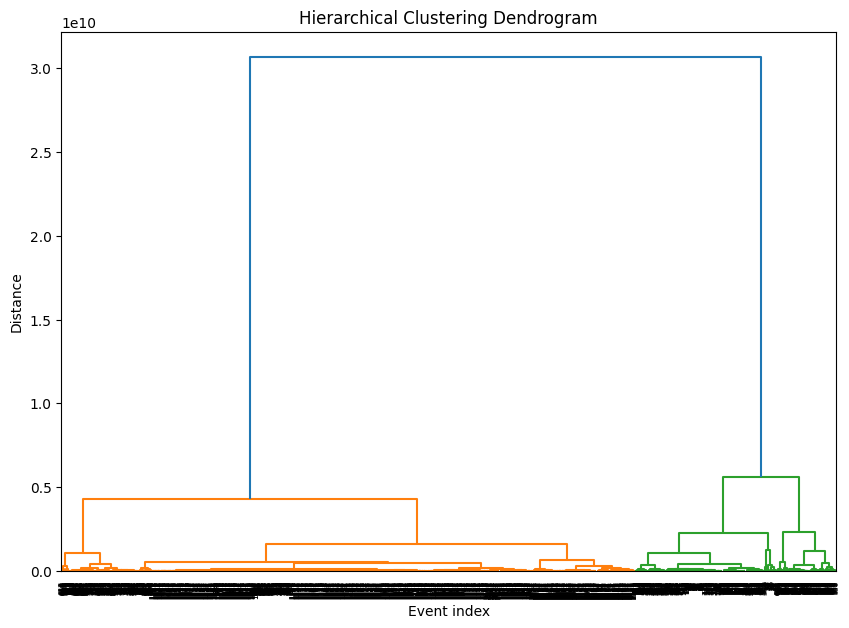

In [3]:
def perform_clustering(locs):
    """Perform hierarchical clustering on earthquake locations."""
    linked = linkage(locs, method='ward')
    return linked

def perform_labeling(linked, k):
    labels = fcluster(linked, k, criterion='maxclust')
    return labels

def plot_dendrogram(linked):
    """Plot the hierarchical clustering dendrogram."""
    plt.figure(figsize=(10, 7))
    dendro = dendrogram(linked)
    color_dict = {color for color in dendro['color_list']}
    num_colors = len(color_dict)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event index')
    plt.ylabel('Distance')
    plt.show()
    
    return num_colors - 1


linked = perform_clustering(locs)
k = plot_dendrogram(linked)
labels = perform_labeling(linked, k)

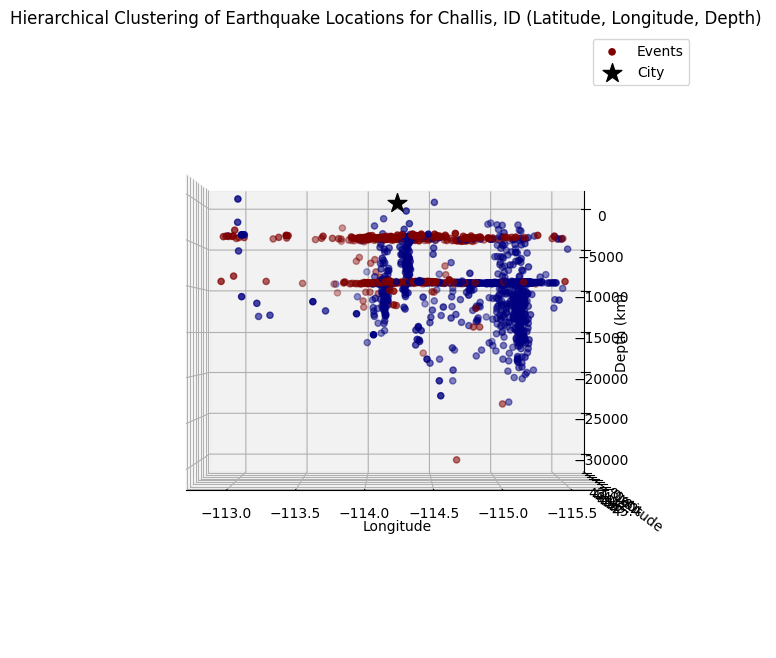

In [4]:
def plot_3d_clusters(locs, labels, city, max_depth, elev, azim):
    """Plot the 3D scatter plot of earthquake locations and clusters."""
    fig = plt.figure(figsize=(10,8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2]*max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')

    ax.set_title(f'Hierarchical Clustering of Earthquake Locations for {city} (Latitude, Longitude, Depth) ')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)

    plt.show()
    

plot_3d_clusters(locs, labels, city, max_depth, elev=0, azim=90)

c:\Users\tompr\anaconda3\envs\tf\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tompr\anaconda3\envs\tf\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\tompr\anaconda3\envs\tf\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\tompr\anaconda3\envs\tf\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\tompr\anaconda3\envs\tf\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


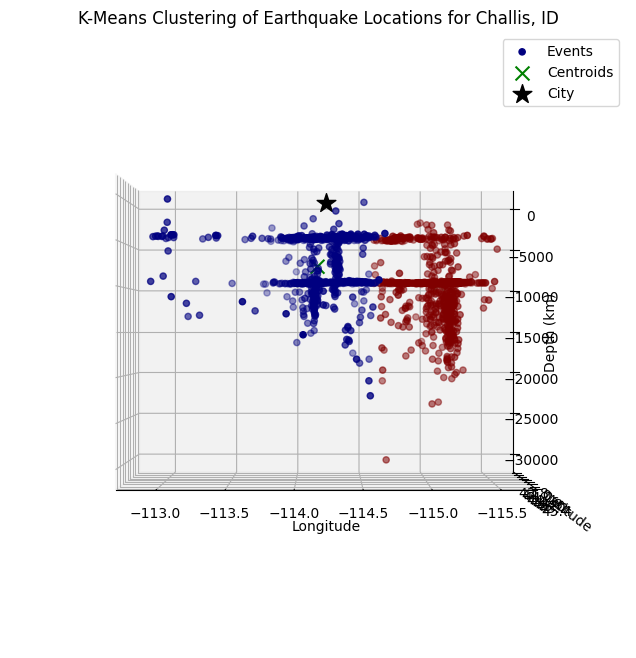

In [5]:
from sklearn.cluster import KMeans

def seismic_kmeans_clusters(locs, k=3, elev=0, azim=90):
    """Plot the k-means clustering results."""
    
    features = locs[:, :3]  # Longitude, Latitude, Depth
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Retrieve cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(10, 8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2] * max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2] * max_depth, c='green', marker='x', s=100, label='Centroids')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title(f'K-Means Clustering of Earthquake Locations for {city}')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)
    plt.show()
    
seismic_kmeans_clusters(locs, k=2, elev=0, azim=90)

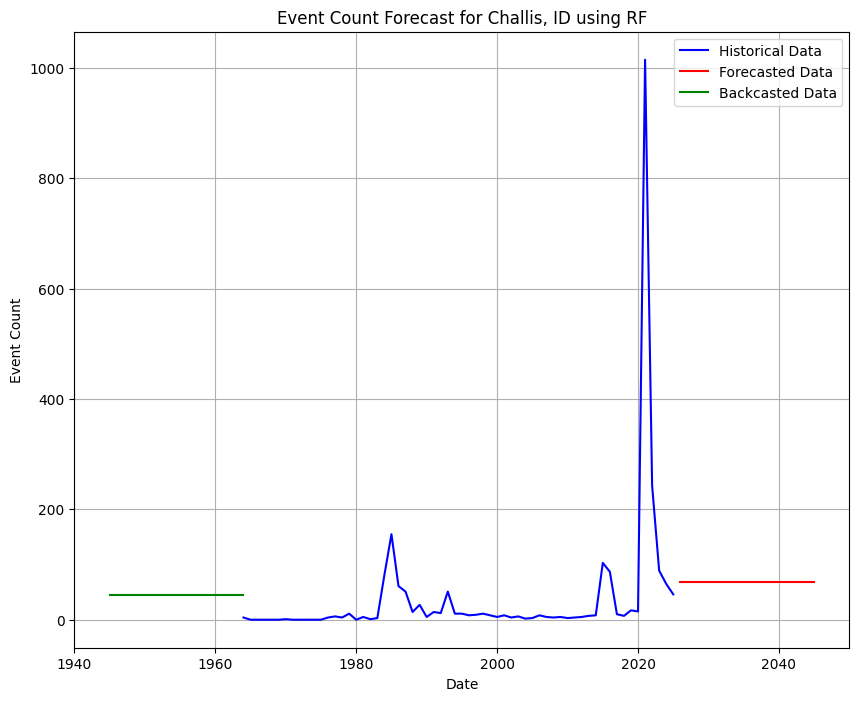


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    45.40
1945-12-31    45.40
1946-12-31    45.40
1947-12-31    45.40
1948-12-31    45.40
1949-12-31    45.40
1950-12-31    45.40
1951-12-31    45.40
1952-12-31    45.40
1953-12-31    45.40
1954-12-31    45.40
1955-12-31    45.40
1956-12-31    45.40
1957-12-31    45.40
1958-12-31    45.40
1959-12-31    45.40
1960-12-31    45.40
1961-12-31    45.40
1962-12-31    45.40
1963-12-31    45.40
Predicted Number of Events for Challis, ID in the next 20 YEs:
2025-12-31    68.11
2026-12-31    68.11
2027-12-31    68.11
2028-12-31    68.11
2029-12-31    68.11
2030-12-31    68.11
2031-12-31    68.11
2032-12-31    68.11
2033-12-31    68.11
2034-12-31    68.11
2035-12-31    68.11
2036-12-31    68.11
2037-12-31    68.11
2038-12-31    68.11
2039-12-31    68.11
2040-12-31    68.11
2041-12-31    68.11
2042-12-31    68.11
2043-12-31    68.11
2044-12-31    68.11


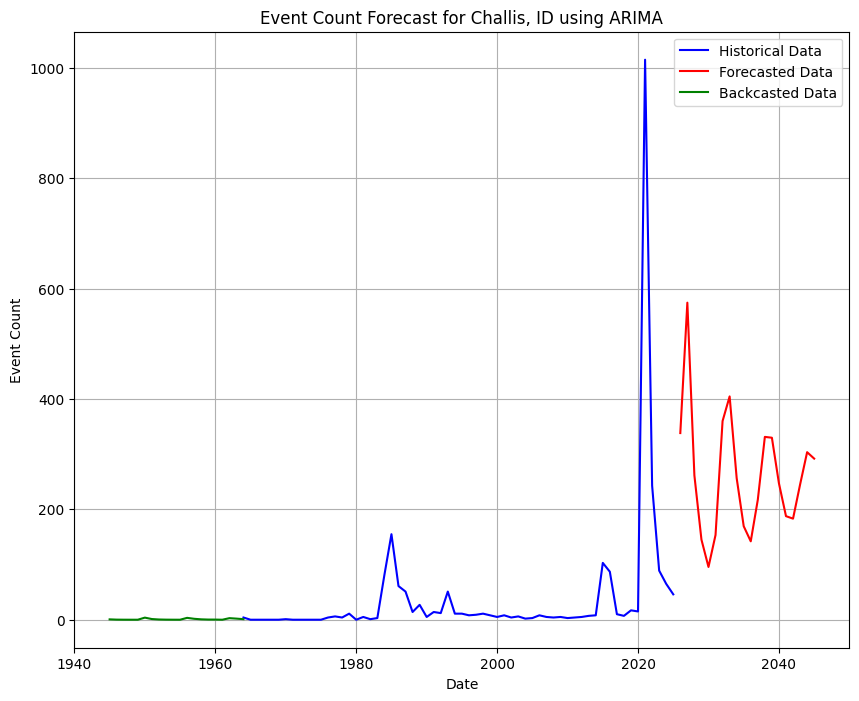


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    0.64
1945-12-31    0.16
1946-12-31    0.03
1947-12-31    0.00
1948-12-31    0.00
1949-12-31    3.79
1950-12-31    1.21
1951-12-31    0.40
1952-12-31    0.13
1953-12-31    0.03
1954-12-31    0.00
1955-12-31    3.38
1956-12-31    1.67
1957-12-31    0.69
1958-12-31    0.28
1959-12-31    0.24
1960-12-31    0.00
1961-12-31    2.82
1962-12-31    1.99
1963-12-31    1.00
Predicted Number of Events Challis, ID for the next 20 YEs:
2025-12-31    338.305990
2026-12-31    574.658225
2027-12-31    261.631138
2028-12-31    145.154324
2029-12-31     95.631008
2030-12-31    153.547005
2031-12-31    360.064709
2032-12-31    404.764833
2033-12-31    256.652995
2034-12-31    169.483476
2035-12-31    142.087466
2036-12-31    217.524576
2037-12-31    331.388850
2038-12-31    329.868742
2039-12-31    247.232358
2040-12-31    187.722748
2041-12-31    183.197080
2042-12-31    244.930563
2043-12-31    303.682012
2044-12-31    292.01

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings

def predict_Seismic_RF(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future/Past time span using Random Forest."""
    
    # Convert times to datetime format
    event_times =  [time.datetime for time in locs[:, 3]]
    
    locs_df = pd.DataFrame({
        'latitude': locs[:, 0],
        'longitude': locs[:, 1],
        'depth': locs[:, 2],
        'event_time': event_times
    })
    locs_df.set_index('event_time', inplace=True)
    
    # Resample data to match the frequency
    event_counts = locs_df.resample(freq).size()
    aggregated_features = locs_df.resample(freq).mean()
    
    event_counts_df = pd.DataFrame(event_counts, columns=['event_count'])
    event_counts_df['latitude'] = aggregated_features['latitude']
    event_counts_df['longitude'] = aggregated_features['longitude']
    event_counts_df['depth'] = aggregated_features['depth']
    event_counts_df['year'] = event_counts_df.index.year
    event_counts_df['month'] = event_counts_df.index.month
    event_counts_df['day'] = event_counts_df.index.day
    
    X = event_counts_df[['year', 'month', 'day', 'latitude', 'longitude', 'depth']]
    y = event_counts_df['event_count']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    future_dates = pd.date_range(event_counts_df.index[-1], periods=duration+1, freq=freq)[1:]
    future_features = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    forecast = rf_model.predict(future_features)
    

    past_dates = pd.date_range(event_counts_df.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    backcast_features = pd.DataFrame({
        'year': past_dates.year,
        'month': past_dates.month,
        'day': past_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    backcast = rf_model.predict(backcast_features)
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts_df.index, event_counts_df['event_count'], label='Historical Data', color='blue')
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using RF')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events for {city} in the next {duration} {freq}s:")
    for date, count in zip(future_dates, forecast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")


def predict_Seismic_ARIMA(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future time span using ARIMA."""
    
    event_times = [time.datetime for time in locs[:, 3]] # Convert to datetime
    
    event_counts = pd.Series(1, index=pd.to_datetime(event_times)).resample(freq).count() # Count number of events per freq
    
    event_counts_reversed = event_counts[::-1] # For Backcasting
    
    warnings.filterwarnings("ignore") # Warning caused by performing back prediction and non-stationary
    model = ARIMA(event_counts, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=duration) # Create forecast
    future_dates = pd.date_range(event_counts.index[-1], periods=duration+1, freq=freq)[1:] # Starting at end of historical data
    
    model = ARIMA(event_counts_reversed, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    backcast = model_fit.forecast(steps=duration) # Create forecast 
    past_dates = pd.date_range(event_counts.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    warnings.filterwarnings("default")
    
    forecast[forecast < 0] = 0
    backcast[backcast < 0] = 0
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts.index, event_counts, label='Historical Data', color='blue')  # Historical data plot
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')  # Forecast data plot
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events {city} for the next {duration} {freq}s:\n{forecast}")

predict_Seismic_RF(city, locs, duration=20, freq='YE')
predict_Seismic_ARIMA(city, locs, duration=20, freq='YE')

In [7]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

def create_heatmap(locs, city="Challis, ID", maxradius=1):
    """Creates a heat map of the location."""
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print("Could not fetch city coordinates for heatmap.")
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=8)
    heat_data = [[loc[1], loc[0]] for loc in locs]
    HeatMap(heat_data, radius=10).add_to(m)
    
    folium.Circle(
        location=(lat, lon),
        radius=maxradius * 1000 * 111,  # Convert degrees to approximate meters
        color='red',
        popup=f"Search Area: {maxradius}° (~{maxradius*111:.2f} km)"
    ).add_to(m)
    
    display(m)
create_heatmap(locs, city="Challis, ID")

In [9]:
import geopandas as gpd
from shapely.geometry import Point

def choropleth_scatterplot(locs, city="Challis, ID"):
    """ Create a choropleth scatter plot map for earthquake data."""
    # Load world data for choropleth
    world = gpd.read_file(gpd.datasets.get_path(r'path_to_your_shapefile/ne_110m_admin_0_countries.shp'))
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print(f"Could not fetch geolocation for {city}.")
        return None
    
    earthquake_gdf = gpd.GeoDataFrame({
    'Longitude': locs[:, 0],
    'Latitude': locs[:, 1],
    'Coordinates': [Point(xy) for xy in zip(locs[:, 0], locs[:, 1])]
    })

    earthquake_gdf = gpd.GeoDataFrame(earthquake_gdf, geometry='Coordinates')
    
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color='lightgray')
    scatter = earthquake_gdf.plot(ax=ax, color='red', markersize=100)
    
    plt.show()
choropleth_scatterplot(locs, city="Challis, ID")
    

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. New sample datasets are now available in the geodatasets package (https://geodatasets.readthedocs.io/en/latest/)

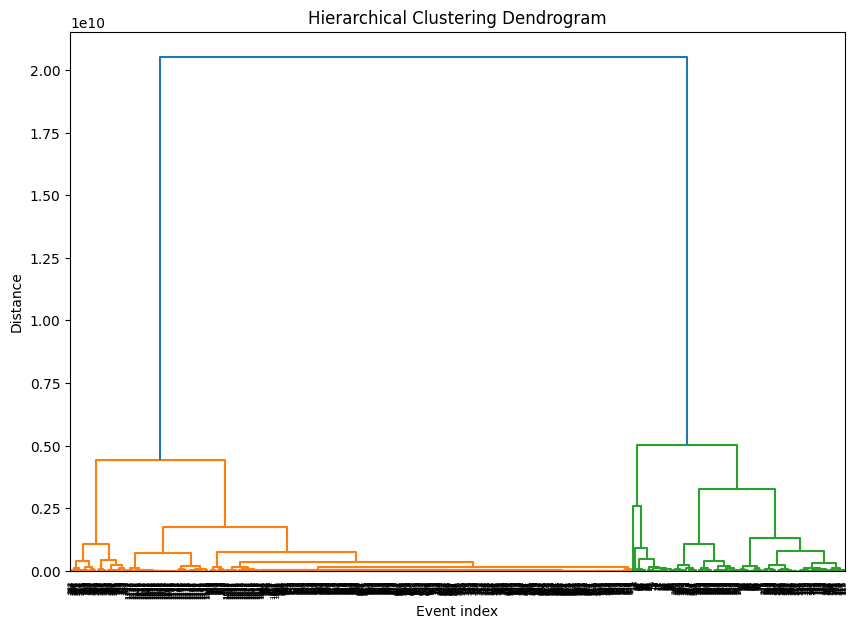

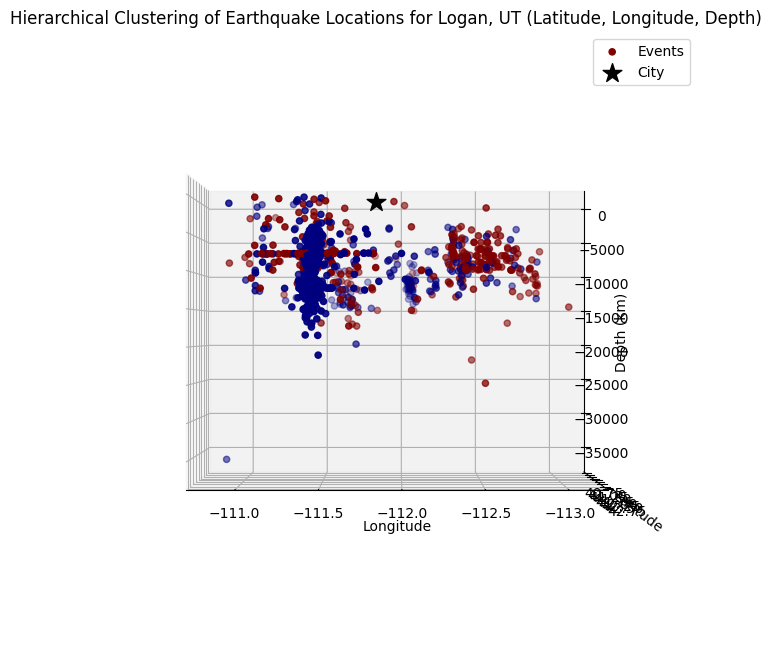

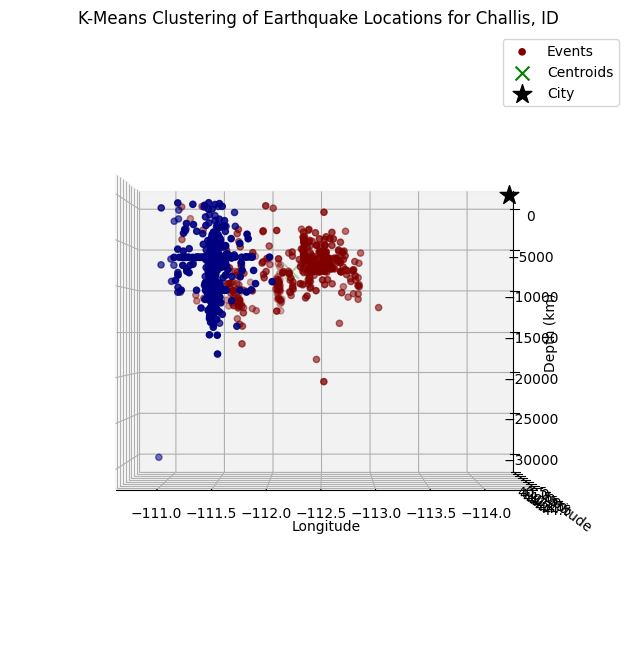

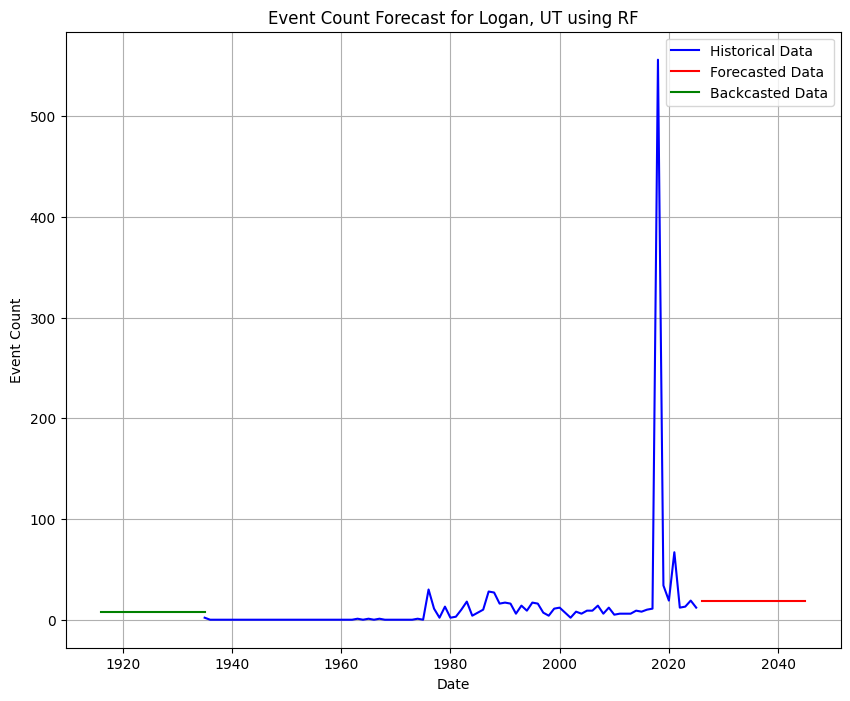


Predicted Number of Events for Logan, UT in the prior 20 YEs:
1915-12-31    7.76
1916-12-31    7.76
1917-12-31    7.76
1918-12-31    7.76
1919-12-31    7.76
1920-12-31    7.76
1921-12-31    7.76
1922-12-31    7.76
1923-12-31    7.76
1924-12-31    7.76
1925-12-31    7.76
1926-12-31    7.76
1927-12-31    7.76
1928-12-31    7.76
1929-12-31    7.76
1930-12-31    7.76
1931-12-31    7.76
1932-12-31    7.76
1933-12-31    7.76
1934-12-31    7.76
Predicted Number of Events for Logan, UT in the next 20 YEs:
2025-12-31    19.04
2026-12-31    19.04
2027-12-31    19.04
2028-12-31    19.04
2029-12-31    19.04
2030-12-31    19.04
2031-12-31    19.04
2032-12-31    19.04
2033-12-31    19.04
2034-12-31    19.04
2035-12-31    19.04
2036-12-31    19.04
2037-12-31    19.04
2038-12-31    19.04
2039-12-31    19.04
2040-12-31    19.04
2041-12-31    19.04
2042-12-31    19.04
2043-12-31    19.04
2044-12-31    19.04


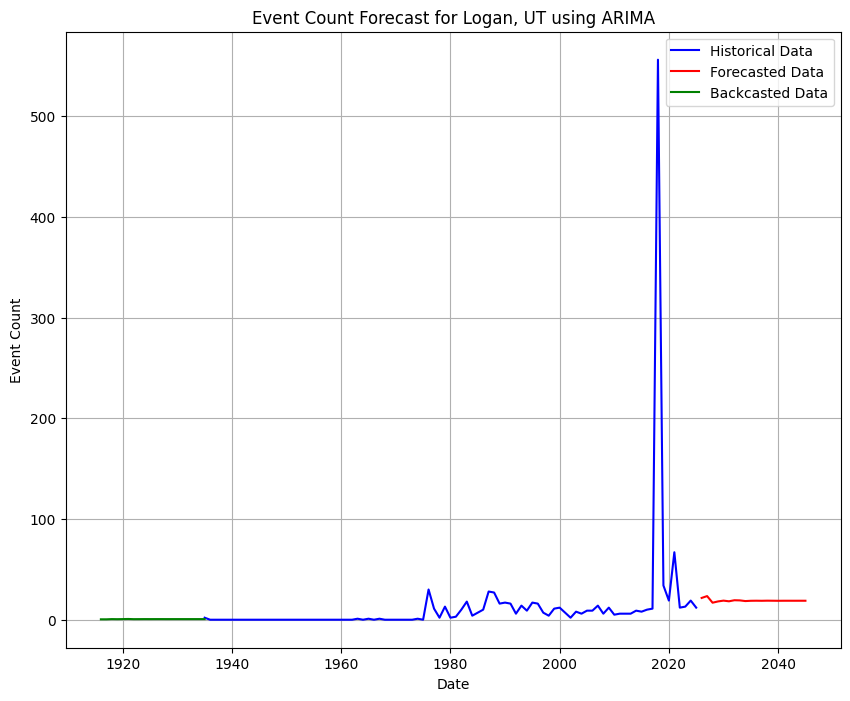


Predicted Number of Events for Logan, UT in the prior 20 YEs:
1915-12-31    0.41
1916-12-31    0.40
1917-12-31    0.62
1918-12-31    0.54
1919-12-31    0.62
1920-12-31    0.75
1921-12-31    0.57
1922-12-31    0.59
1923-12-31    0.62
1924-12-31    0.61
1925-12-31    0.62
1926-12-31    0.63
1927-12-31    0.61
1928-12-31    0.61
1929-12-31    0.62
1930-12-31    0.62
1931-12-31    0.62
1932-12-31    0.62
1933-12-31    0.61
1934-12-31    0.62
Predicted Number of Events Logan, UT for the next 20 YEs:
2025-12-31    21.621679
2026-12-31    23.460904
2027-12-31    16.899919
2028-12-31    18.165098
2029-12-31    18.954064
2030-12-31    18.297199
2031-12-31    19.343006
2032-12-31    19.188173
2033-12-31    18.516131
2034-12-31    18.799137
2035-12-31    18.870462
2036-12-31    18.798279
2037-12-31    18.902051
2038-12-31    18.853920
2039-12-31    18.795924
2040-12-31    18.840833
2041-12-31    18.843097
2042-12-31    18.834516
2043-12-31    18.844492
2044-12-31    18.836992
Freq: YE-DEC, Name:

In [ ]:
def perform_Seismitc_Analysis(city="Challis, ID", maxradius=1, data_starttime="1900-10-01", 
                              data_endtime="2024-10-11", elev=0, azim=90,clusters=0):   
    """Perform full seismic analysis and estimation"""
    
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius, 
                                  starttime=data_starttime, endtime=data_endtime)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
    

    linked = perform_clustering(locs)
    if clusters == 0:
        k = plot_dendrogram(linked)
    else:
        k = clusters
    labels = perform_labeling(linked, k)

    plot_3d_clusters(locs, labels, city, max_depth, elev=elev, azim=azim)
    seismic_kmeans_clusters(locs, k=k, elev=elev, azim=azim)
    create_heatmap(locs, city=city)
    
    predict_Seismic_RF(city, locs, duration=20, freq='YE')
    predict_Seismic_ARIMA(city, locs, duration=20, freq='YE')
    

perform_Seismitc_Analysis(city="Logan, UT", maxradius=1, elev=0, azim=90)

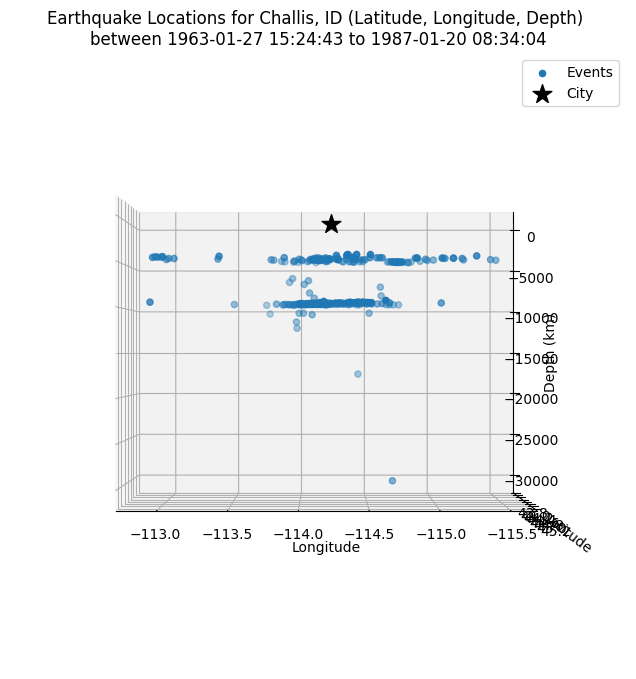

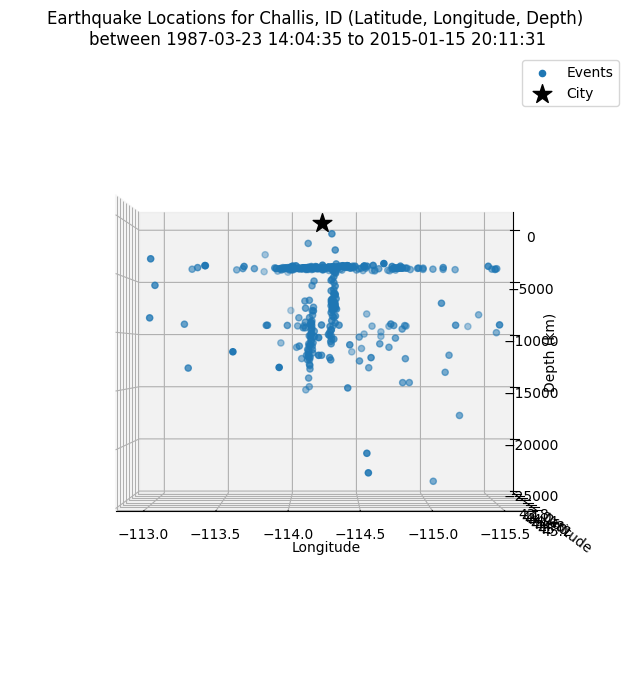

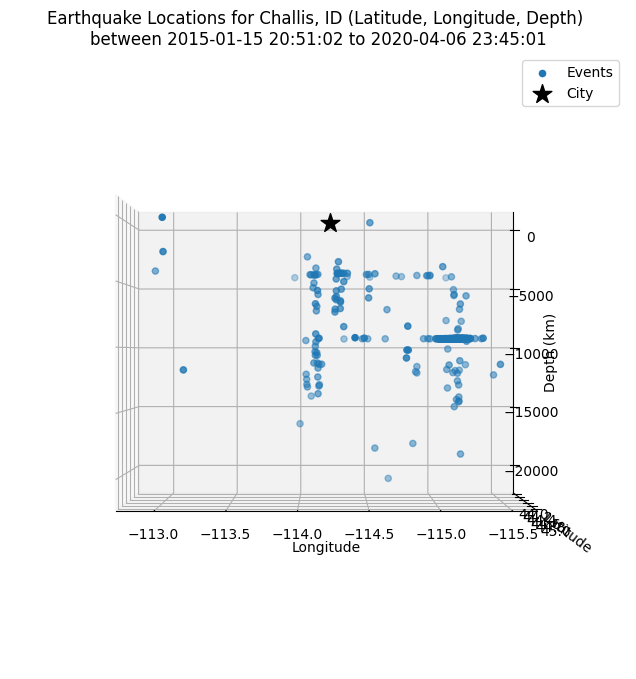

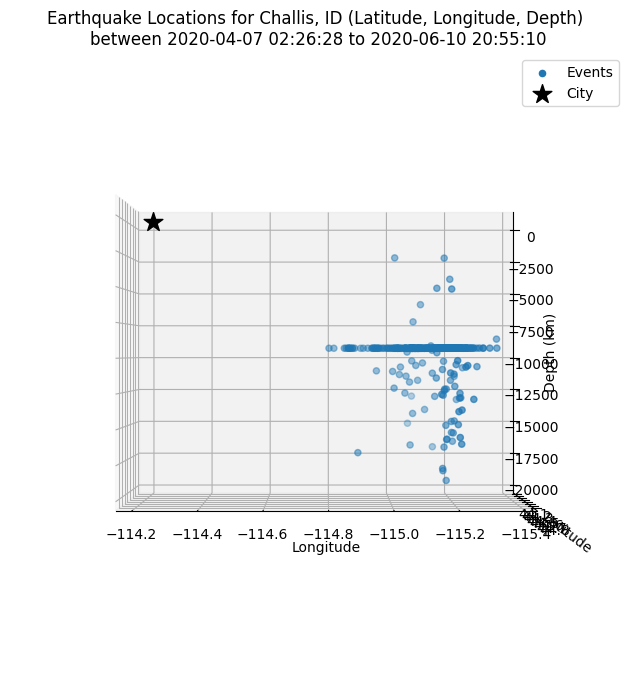

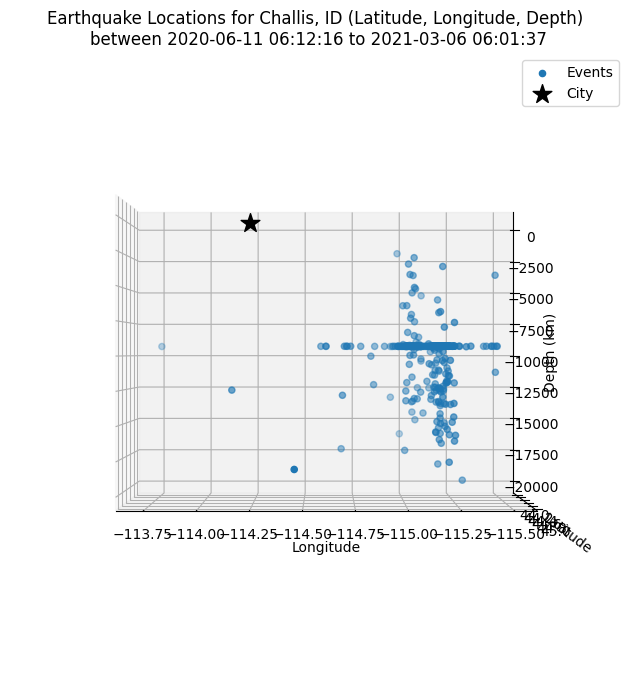

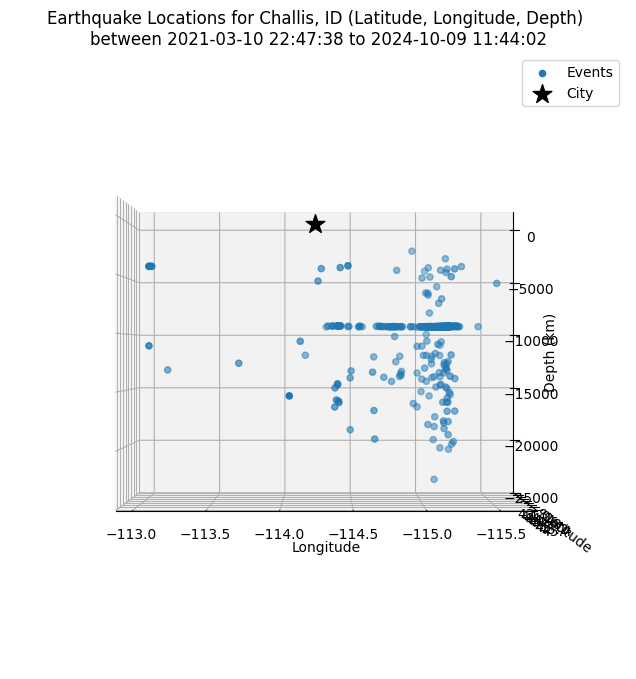

In [ ]:
def split_by_date(locs, num_splits=6):
    """Splits the data into equals sections"""
    splits = np.array_split(locs, num_splits)
    return splits

def show_progression(city="Challis, ID", maxradius=1, elev=0, azim=90):
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
        
        split_locs = split_by_date(locs,6)
        
        lat, lon = get_geolocation(city=city)

        
        # Create a 3D plot for each split
        for i, split in enumerate(split_locs):
            
            
            start_time = split[0, 3]
            end_time = split[-1, 3]
            
            # Get Time range of each split
            start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
            end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
            time_range_str = f"{start_time_str} to {end_time_str}"
            
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(split[:, 0], split[:, 1], split[:, 2] * max_depth, 
                                 label=f'Events', marker='o')
        
            ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_zlabel('Depth (km)')

            ax.set_title(f"""Earthquake Locations for {city} (Latitude, Longitude, Depth) \nbetween {time_range_str}""")
            ax.legend()

            ax.view_init(elev=elev, azim=azim)

            plt.show()
    else:
        return None

show_progression(city="Challis, ID", maxradius=1, elev=0, azim=90)